In [ ]:
import voxelwise_tutorials
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess
from AOTanalysis.bandedRR.construct_features import (
    construct_features_motion_energy_from_subses,
    construct_features_sbert_embeddings_from_subses,
)
from AOTanalysis.bandedRR.construct_target import (
    construct_target_data_from_session_flatten_masked
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from himalaya.backend import set_backend


from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from sklearn import set_config
from himalaya.kernel_ridge import ColumnKernelizer
from voxelwise_tutorials.utils import explainable_variance
from AOTanalysis.bandedRR.utils import split_single_array
from AOTglmsingle.glmoutput_save_nifti import get_affine_matrix
from AOTanalysis.bandedRR.utils import reshape_from_flatten_masked_to_wholebrain
from himalaya.scoring import r2_score

import os


import joblib
import nibabel as nib

import voxelwise_tutorials
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess
from AOTaccess.expdesign_access import ExpDesignAccess
from AOTanalysis.bandedRR.construct_features import (
    construct_features_motion_energy,
    construct_features_sbert_embeddings,
    construct_features_sbert_embeddings_PCA,
    construct_features_motion_energy_from_subses,
    construct_features_sbert_embeddings_from_subses,
)
from AOTanalysis.bandedRR.construct_target import (
    construct_target_data_from_session_flatten_masked,
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from himalaya.backend import set_backend


from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from sklearn import set_config
from himalaya.kernel_ridge import ColumnKernelizer
from voxelwise_tutorials.utils import explainable_variance
from AOTanalysis.bandedRR.utils import split_single_array
from AOTglmsingle.glmoutput_save_nifti import get_affine_matrix
from AOTanalysis.bandedRR.utils import reshape_from_flatten_masked_to_wholebrain
from himalaya.scoring import r2_score

import os

import joblib
import nibabel as nib

def data_construct(
    sub,
    ses,
    feature,
    Ycentered=True,
    Xcentered=False,
):
    expdesign_access = ExpDesignAccess()
    video_indexes = expdesign_access.get_session_video_indexes(sub, ses)
    video_betas = construct_target_data_from_session_flatten_masked(
        sub, ses, centered=Ycentered
    )
    if video_betas.shape[0] != len(video_indexes):
        # cut
        video_betas = video_betas[: len(video_indexes)]
    print(f"Shape of video betas: {video_betas.shape}")
    if feature == "motion":
        X = construct_features_motion_energy_from_subses(sub, ses, centered=Xcentered)
    elif feature == "semantic":
        X = construct_features_sbert_embeddings_from_subses(
            sub, ses, centered=Xcentered
        )
    elif feature == "semantic_PCA":
        X = construct_features_sbert_embeddings_PCA_from_subses(sub, ses, centered=Xcentered)
    elif feature == "semantic_SAE":
        X = construct_features_sbert_embeddings_SAE(sub, ses, centered=Xcentered)
    print(f"Shape of X: {X.shape}")

    y = video_betas
    print(f"Shape of y: {y.shape}")

    # split the data
    Xtrain, Xtest = split_single_array(X, n_splits=2)
    ytrain, ytest = split_single_array(y, n_splits=2)
    print(f"Shape of Xtrain: {Xtrain.shape}")
    print(f"Shape of Xtest: {Xtest.shape}")
    print(f"Shape of ytrain: {ytrain.shape}")
    print(f"Shape of ytest: {ytest.shape}")

    if np.isnan(y).any() or np.isinf(y).any():
        y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

    return Xtrain, ytrain, Xtest, ytest


sub = 3
train_ses = 1
Ycentered = True
direction = "fw"

model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside/model_sub{sub}_feature_semantic_PCA_trainses_1_testinside.joblib"
R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside/R2_score_single_sub{sub}_semantic_PCA_train_1_testinside.nii.gz"

model = joblib.load(model_path)

glmsingle_access = GLMSingleAccess()
stimuli_info_access = StimuliInfoAccess()

Xtrain, ytrain, Xtest, ytest = data_construct(
    sub=sub,
    ses=train_ses,
    feature="semantic_PCA",
    Ycentered=Ycentered,
    Xcentered=False,
)

print(f"Shape of test_X: {Xtest.shape}")
print(f"Shape of test_y: {ytest.shape}")


def mask_construct(R2_file, threshold=0.1):
    R2 = nib.load(R2_file).get_fdata()
    mask = np.zeros_like(R2)
    mask[R2 > threshold] = 1
    return mask


print(f"Shape of test_video_betas: {ytest.shape}")  # (360,641846)
len_test = ytest.shape[0]
list_of_test_video_betas_glm = [ytest[i] for i in range(len_test)]
list_of_test_video_betas_glm_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(list_of_test_video_betas_glm[i], sub=sub)
    for i in range(len_test)
]
print(
    f"len of list_of_test_video_betas_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

print(f"Shape of test_X: {Xtest.shape}")

/tank/zhangs/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tank/zhangs/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_01.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_02.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_03.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_04.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_05.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_01_run_06.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/a

ValueError: feature must be 'motion' or 'semantic'

In [2]:
print(f"Shape of test_X: {Xtest.shape}")
print(
    f"len of list_of_test_video_betas_glm_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_glm_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

Shape of test_X: (360, 768)
len of list_of_test_video_betas_glm_wholebrain: 360
Shape of list_of_test_video_betas_glm_wholebrain[0]: (87, 110, 81)


In [3]:
from himalaya.backend import set_backend

set_backend("torch_cuda", on_error="warn")
#set_backend("numpy")
test_X = np.array(Xtest)
model_predictions = model.predict(test_X)

print(f"Shape of model_predictions: {model_predictions.shape}")

Shape of model_predictions: torch.Size([360, 665059])


In [4]:
model_predictions = np.array(model_predictions)
print(f"Shape of model_predictions: {model_predictions.shape}")
len_test = model_predictions.shape[0]
list_of_model_predictions_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(model_predictions[i], sub)
    for i in range(len_test)
]
print(
    f"len of list_of_model_predictions_wholebrain: {len(list_of_model_predictions_wholebrain)}"
)


Shape of model_predictions: (360, 665059)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-003_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (87, 110, 81)
Shape of R2 mask: (87, 110, 81)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-003_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (87, 110, 81)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-003_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (87, 110, 81)
Shape of R2 mask: (87, 110, 81)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-003_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (87, 110, 81)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-003_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (87, 110, 81)
Shape of R2 mask: (87, 110, 81)
Loaded R2 from /tank/shared/2024/visual/AO

In [5]:
def mask_and_flatten_list_of_data(list_of_data, mask):
    masked_data = [data[mask == 1] for data in list_of_data]
    flattened_masked_data = [data.flatten() for data in masked_data]
    return flattened_masked_data



In [6]:
prediction_R2_mask = mask_construct(R2_file)
print(f"Shape of prediction_R2_mask: {prediction_R2_mask.shape}")


flatten_and_masked_model_predictions = mask_and_flatten_list_of_data(
    list_of_model_predictions_wholebrain, prediction_R2_mask
)

flatten_and_masked_test_video_betas_glm = mask_and_flatten_list_of_data(
    list_of_test_video_betas_glm_wholebrain, prediction_R2_mask
)

print(
    f"Shape of flatten_and_masked_model_predictions: {flatten_and_masked_model_predictions[0].shape}"
)

print(
    f"Shape of flatten_and_masked_test_video_betas_glm: {flatten_and_masked_test_video_betas_glm[0].shape}"
)   


# L2 normalization both model_predictions and test_video_betas
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(flatten_and_masked_model_predictions)
flatten_and_masked_model_predictions = normalizer.transform(
    flatten_and_masked_model_predictions
)
flatten_and_masked_test_video_betas_glm = normalizer.transform(
    flatten_and_masked_test_video_betas_glm
)

# pick the first n data
# n = 500
# flatten_and_masked_model_predictions = flatten_and_masked_model_predictions[:n]
# flatten_and_masked_test_video_betas_glm = flatten_and_masked_test_video_betas_glm[:n]

Shape of prediction_R2_mask: (87, 110, 81)
Shape of flatten_and_masked_model_predictions: (3688,)
Shape of flatten_and_masked_test_video_betas_glm: (3688,)


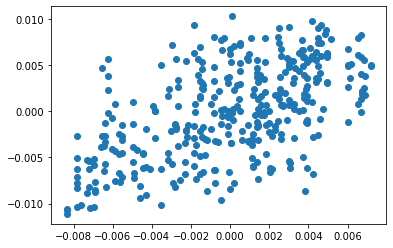

In [7]:
import seaborn as sns
# sns.heatmap(flatten_and_masked_model_predictions)
import matplotlib.pyplot as plt
plt.plot(
    np.array(flatten_and_masked_model_predictions).mean(1),
    np.array(flatten_and_masked_test_video_betas_glm).mean(1),
    "o",
)

In [8]:
# for each prediction, get the most similar betas
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances


def get_most_similar_beta(prediction, betas,metric_func=cosine_similarity):
    similarity = metric_func([prediction], betas)
    most_similar_index = np.argmax(similarity)
    return most_similar_index


most_similar_betas = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas: {len(most_similar_betas)}")
print(f"most_similar_betas: {most_similar_betas}")


# pearsonr from sklearn


most_similar_betas_euclidean = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=euclidean_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_euclidean: {len(most_similar_betas_euclidean)}")
print(f"most_similar_betas_euclidean: {most_similar_betas_euclidean}")

most_similar_betas_manhattan = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=manhattan_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_manhattan: {len(most_similar_betas_manhattan)}")
print(f"most_similar_betas_manhattan: {most_similar_betas_manhattan}")

most_similar_betas_cosine = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=cosine_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_cosine: {len(most_similar_betas_cosine)}")
print(f"most_similar_betas_cosine: {most_similar_betas_cosine}")




Shape of most_similar_betas: 360
most_similar_betas: [216, 261, 243, 173, 4, 206, 208, 283, 208, 9, 71, 208, 75, 216, 78, 327, 327, 17, 205, 78, 9, 21, 261, 65, 327, 327, 26, 183, 318, 18, 205, 31, 206, 33, 119, 265, 36, 75, 261, 105, 261, 119, 42, 205, 44, 183, 70, 216, 265, 4, 206, 119, 195, 53, 344, 216, 173, 261, 265, 59, 95, 278, 327, 137, 70, 261, 173, 344, 199, 75, 70, 261, 75, 33, 75, 278, 293, 60, 75, 53, 208, 31, 261, 195, 261, 216, 9, 87, 173, 293, 119, 184, 190, 93, 283, 95, 208, 53, 95, 131, 208, 278, 344, 265, 105, 330, 126, 344, 61, 75, 74, 173, 330, 283, 105, 283, 75, 70, 105, 119, 95, 75, 149, 31, 75, 243, 4, 18, 109, 119, 131, 93, 278, 261, 243, 3, 261, 137, 17, 300, 131, 237, 126, 4, 216, 4, 265, 60, 65, 283, 105, 31, 70, 131, 173, 78, 71, 261, 105, 93, 33, 119, 265, 163, 105, 261, 18, 119, 198, 347, 227, 227, 172, 261, 173, 163, 70, 4, 227, 206, 227, 216, 243, 265, 184, 74, 206, 237, 105, 4, 190, 265, 261, 60, 261, 278, 119, 283, 206, 4, 261, 237, 18, 205, 105, 205,

In [9]:
from scipy.stats import pearsonr


def scores_for_a_prediction(prediction,betas):
    scores = [pearsonr(prediction,beta)[0] for beta in betas]
    return scores


def get_most_similar_beta_corr(prediction, betas):
    scores = scores_for_a_prediction(prediction,betas)
    most_similar_index = np.argmax(scores)
    return most_similar_index

most_similar_betas_corr = [get_most_similar_beta_corr(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_corr: {len(most_similar_betas_corr)}")
print(f"most_similar_betas_corr: {most_similar_betas_corr}")

Shape of most_similar_betas_corr: 360
most_similar_betas_corr: [216, 261, 243, 173, 4, 206, 184, 283, 208, 9, 71, 184, 75, 216, 237, 327, 327, 17, 205, 237, 95, 13, 261, 173, 327, 327, 330, 183, 318, 18, 205, 31, 206, 33, 119, 265, 36, 75, 261, 105, 261, 119, 42, 205, 44, 183, 70, 216, 265, 4, 206, 119, 195, 53, 278, 216, 173, 261, 265, 59, 95, 278, 327, 137, 70, 143, 173, 278, 199, 75, 70, 261, 75, 33, 75, 278, 293, 60, 75, 53, 80, 210, 143, 195, 206, 216, 9, 87, 173, 293, 119, 184, 190, 93, 264, 95, 208, 53, 95, 131, 173, 278, 278, 265, 114, 330, 243, 278, 300, 75, 183, 173, 330, 264, 114, 283, 75, 70, 118, 119, 95, 75, 149, 210, 75, 243, 4, 18, 109, 119, 131, 93, 278, 261, 243, 141, 261, 137, 17, 300, 253, 237, 243, 4, 216, 206, 265, 60, 173, 283, 118, 210, 61, 131, 184, 237, 71, 261, 105, 93, 33, 119, 265, 163, 208, 261, 18, 149, 353, 347, 227, 227, 258, 143, 173, 163, 70, 4, 227, 206, 227, 216, 243, 265, 184, 74, 206, 237, 118, 4, 190, 265, 261, 60, 143, 278, 119, 283, 206, 4, 261

Shape of similarity_matrix: (360, 360)


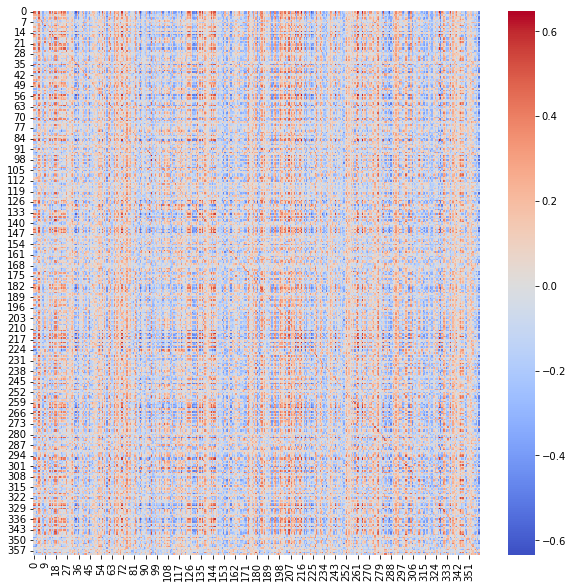

In [10]:
# draw a picture to show the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

similarity_matrix = [scores_for_a_prediction(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]

similarity_matrix = similarity_matrix
similarity_matrix = np.array(similarity_matrix)



print(f"Shape of similarity_matrix: {similarity_matrix.shape}")
plt.figure(figsize=(10, 10))
sns.heatmap(similarity_matrix, cmap="coolwarm", center=0)
plt.show()